In [ ]:
!pip install yahooquery


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [ ]:
!pip install yahooquery pandas_ta tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=07cb8e11246994dc8bb019b1290794379a96f0d56eccfd02e817722548824610
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
!pip install pandas_ta


In [ ]:
import pandas_ta as ta

In [ ]:
def get_stock_data(symbol: str, period: str="5y", interval: str="1d", start=None, end=None):
    t = Ticker(symbol, asynchronous=True)
    stock_data = t.history(period=period, interval=interval, start=start, end=end)
    stock_data = stock_data.reset_index(level=0)
    stock_data = stock_data.drop("symbol", axis=1)
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data.columns = stock_data.columns.str.capitalize()
    return stock_data

In [ ]:
from yahooquery import Ticker


In [ ]:
stock_df = get_stock_data("^NSEI", period="5y", interval="1d")
close_prices = stock_df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close_prices = scaler.fit_transform(np.array(close_prices).reshape(-1,1))


In [ ]:
train_size = int(len(scaled_close_prices) * 0.65)
test_size = len(scaled_close_prices) - train_size
train_data, test_data = scaled_close_prices[0:train_size,:], scaled_close_prices[train_size:len(scaled_close_prices),:1]


In [ ]:
# Define function to create dataset with correct time steps
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

# Prepare data for LSTM
time_steps = 99  # Adjusted time_steps parameter
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps-1, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Fix the input shape issue
X_train = X_train[:, :-1, :]  # Remove the last time step
X_test = X_test[:, :-1, :]

# Fit the model with the adjusted input data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=0, batch_size=64, verbose=1)

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

11/11 [==============================] - 0s 37ms/step


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 9045.221692407138
Test RMSE: 9941.779803445133


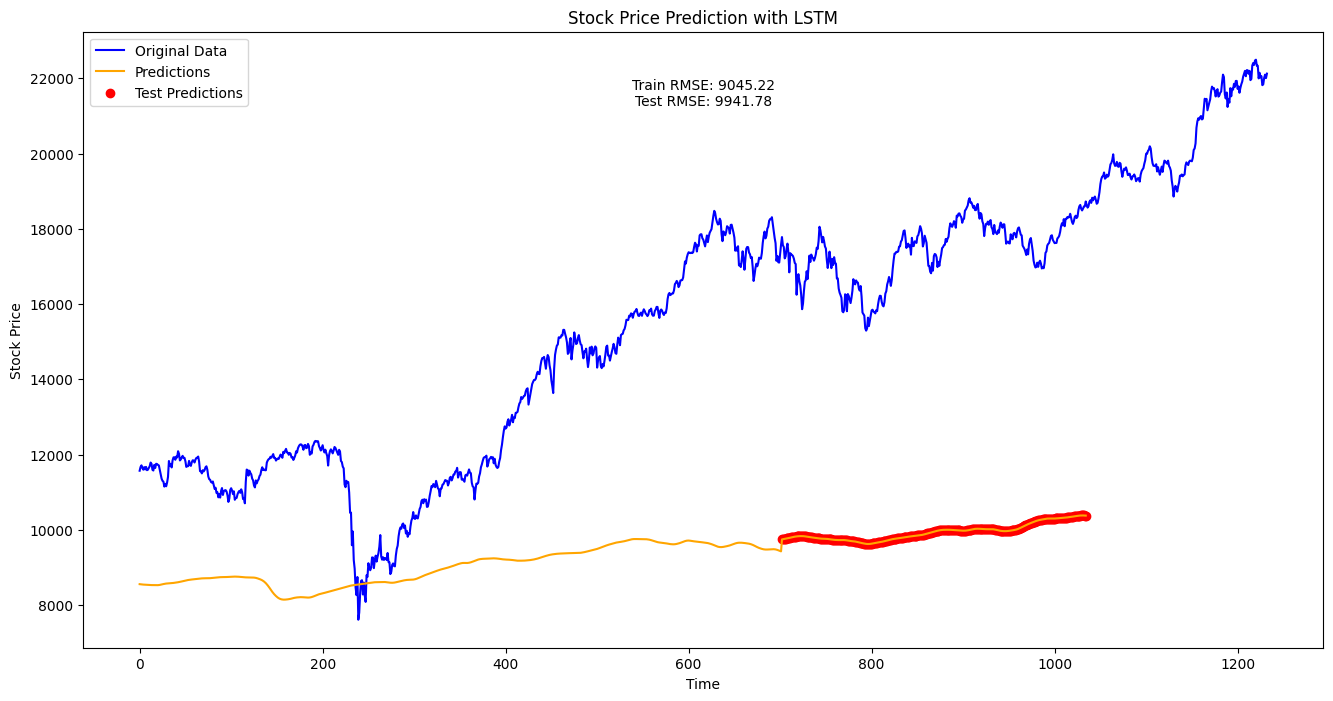

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(close_prices, label='Original Data', color='blue')
plt.plot(np.concatenate([train_predictions, test_predictions]), label='Predictions', color='orange')
plt.scatter(np.arange(len(X_train), len(X_train) + len(X_test)), test_predictions, label='Test Predictions', color='red')
plt.title('Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Plot RMSE value
plt.text(0.5, 0.9, f'Train RMSE: {train_rmse:.2f}\nTest RMSE: {test_rmse:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

In [ ]:
import plotly.graph_objects as go

# Plot with Plotly for interactive visualization
fig = go.Figure()

# Original data and predictions
fig.add_trace(go.Scatter(x=np.arange(len(close_prices)), y=close_prices, mode='lines', name='Original Data'))
fig.add_trace(go.Scatter(x=np.arange(len(train_predictions)), y=train_predictions[:,0], mode='lines', name='Train Predictions', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=np.arange(len(train_predictions), len(train_predictions) + len(test_predictions)), y=test_predictions[:,0], mode='lines', name='Test Predictions', line=dict(color='red')))


fig.add_trace(go.Scatter(x=np.arange(len(close_prices)), y=pd.Series(close_prices).rolling(window=50).mean(), mode='lines', name='50-day Moving Average', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=np.arange(len(close_prices)), y=pd.Series(close_prices).rolling(window=200).mean(), mode='lines', name='200-day Moving Average', line=dict(color='green')))

# Add buy/sell signals based on specific trading strategies
# Example: Add markers for buy signals when the short-term moving average crosses above the long-term moving average
buy_signals = np.where(pd.Series(close_prices).rolling(window=50).mean() > pd.Series(close_prices).rolling(window=200).mean(), close_prices, None)
sell_signals = np.where(pd.Series(close_prices).rolling(window=50).mean() < pd.Series(close_prices).rolling(window=200).mean(), close_prices, None)
fig.add_trace(go.Scatter(x=np.arange(len(close_prices)), y=buy_signals, mode='markers', name='Buy Signals', marker=dict(color='green', symbol='triangle-up', size=10)))
fig.add_trace(go.Scatter(x=np.arange(len(close_prices)), y=sell_signals, mode='markers', name='Sell Signals', marker=dict(color='red', symbol='triangle-down', size=10)))

# Add news events or corporate actions
# Example: Add annotations for earnings releases or product launches
fig.add_annotation(x=50, y=close_prices[50], text='Earnings Release', showarrow=True, arrowhead=2, arrowcolor='blue', font=dict(color='blue'))

# Update layout
fig.update_layout(title='Stock Price Prediction with LSTM',
                  xaxis_title='Time',
                  yaxis_title='Stock Price',
                  legend=dict(x=0.02, y=0.98),
                  height=600,
                  width=1000)

fig.show()
